<a href="https://colab.research.google.com/github/june1st/GoogleColab/blob/master/QRNNtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SIN

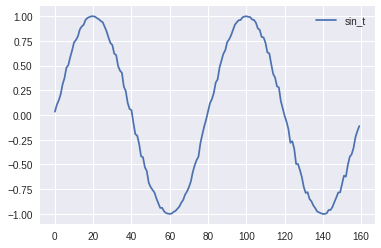

In [1]:
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
random.seed(0)
# 乱数の係数
random_factor = 0.05
# サイクルあたりのステップ数
steps_per_cycle = 80
# 生成するサイクル数
number_of_cycles = 50

df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
df[["sin_t"]].head(steps_per_cycle * 2).plot()

In [0]:
def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1, n_prev = 100):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data(df.iloc[0:ntrn], n_prev)
    X_test, y_test = _load_data(df.iloc[ntrn:], n_prev)

    return (X_train, y_train), (X_test, y_test)

In [0]:
length_of_sequences = 100
(X_train, y_train), (X_test, y_test) = train_test_split(df[["sin_t"]], n_prev =length_of_sequences)  


In [4]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM


in_out_neurons = 1
hidden_neurons = 300

model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))  
model.add(Dense(in_out_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.fit(X_train, y_train, batch_size=600, nb_epoch=15, validation_split=0.05) 

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 3325 samples, validate on 176 samples
Epoch 1/15
3325/3325 [==============================] - 4s 1ms/step - loss: 0.2223 - val_loss: 0.0263
Epoch 2/15
3325/3325 [==============================] - 2s 512us/step - loss: 0.0396 - val_loss: 0.0389
Epoch 3/15
3325/3325 [==============================] - 2s 508us/step - loss: 0.0121 - val_loss: 6.9358e-04
Epoch 4/15
3325/3325 [==============================] - 2s 508us/step - loss: 0.0034 - val_loss: 0.0252
Epoch 5/15
3325/3325 [==============================] - 2s 513us/step - loss: 0.0114 - val_loss: 0.0074
Epoch 6/15
3325/3325 [==============================] - 2s 507us/step - loss: 0.0122 - val_loss: 0.0048
Epoch 7/15
3325/3325 [==============================] - 2s 508us/step - loss: 0.0078 - val_loss: 0.0077
Epoch 8/15
3325/3325 [==============================] - 2s 512us/step - loss: 0.0081 - val_loss: 0.0062
Epoch 9/15
3325/3325 [==============================] - 2s 508us/step - loss: 0.0076 - val_loss: 0.0069
Epoch 10/15
332

In [0]:
predicted = model.predict(X_test) 

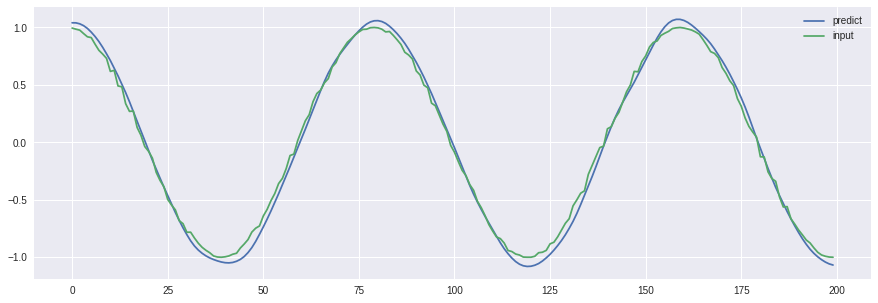

In [6]:
dataf =  pd.DataFrame(predicted[:200])
dataf.columns = ["predict"]
dataf["input"] = y_test[:200]
dataf.plot(figsize=(15, 5))

In [7]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot, plot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

ModuleNotFoundError: ignored

QRNN

In [0]:
from keras.layers import Input, Dense
from keras.layers import Dense, Dropout, Activation, Embedding, SpatialDropout1D
from keras.models import Model

In [0]:
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.layers import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length

def _dropout(x, level, noise_shape=None, seed=None):
    x = K.dropout(x, level, noise_shape, seed)
    x *= (1. - level) # compensate for the scaling by the dropout
    return x


class QRNN(Layer):
    '''Quasi RNN
    # Arguments
        units: dimension of the internal projections and the final output.
    # References
        - [Quasi-recurrent Neural Networks](http://arxiv.org/abs/1611.01576)
    '''
    def __init__(self, units, window_size=2, stride=1,
                 return_sequences=False, go_backwards=False, 
                 stateful=False, unroll=False, activation='tanh',
                 kernel_initializer='uniform', bias_initializer='zero',
                 kernel_regularizer=None, bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, 
                 dropout=0, use_bias=True, input_dim=None, input_length=None,
                 **kwargs):
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards
        self.stateful = stateful
        self.unroll = unroll

        self.units = units 
        self.window_size = window_size
        self.strides = (stride, 1)

        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = dropout
        self.supports_masking = True
        self.input_spec = [InputSpec(ndim=3)]
        self.input_dim = input_dim
        self.input_length = input_length
        if self.input_dim:
            kwargs['input_shape'] = (self.input_length, self.input_dim)
        super(QRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        self.input_dim = input_shape[2]
        self.input_spec = InputSpec(shape=(batch_size, None, self.input_dim))
        self.state_spec = InputSpec(shape=(batch_size, self.units))

        self.states = [None]
        if self.stateful:
            self.reset_states()

        kernel_shape = (self.window_size, 1, self.input_dim, self.units * 3)
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(name='bias', 
                                        shape=(self.units * 3,),
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)

        self.built = True

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        length = input_shape[1]
        if length:
            length = conv_output_length(length + self.window_size - 1,
                                        self.window_size, 'valid',
                                        self.strides[0])
        if self.return_sequences:
            return (input_shape[0], length, self.units)
        else:
            return (input_shape[0], self.units)

    def compute_mask(self, inputs, mask):
        if self.return_sequences:
            return mask
        else:
            return None

    def get_initial_states(self, inputs):
        # build an all-zero tensor of shape (samples, units)
        initial_state = K.zeros_like(inputs)  # (samples, timesteps, input_dim)
        initial_state = K.sum(initial_state, axis=(1, 2))  # (samples,)
        initial_state = K.expand_dims(initial_state)  # (samples, 1)
        initial_state = K.tile(initial_state, [1, self.units])  # (samples, units)
        initial_states = [initial_state for _ in range(len(self.states))]
        return initial_states

    def reset_states(self, states=None):
        if not self.stateful:
            raise AttributeError('Layer must be stateful.')
        if not self.input_spec:
            raise RuntimeError('Layer has never been called '
                               'and thus has no states.')

        batch_size = self.input_spec.shape[0]
        if not batch_size:
            raise ValueError('If a QRNN is stateful, it needs to know '
                             'its batch size. Specify the batch size '
                             'of your input tensors: \n'
                             '- If using a Sequential model, '
                             'specify the batch size by passing '
                             'a `batch_input_shape` '
                             'argument to your first layer.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a '
                             '`batch_shape` argument to your Input layer.')

        if self.states[0] is None:
            self.states = [K.zeros((batch_size, self.units))
                           for _ in self.states]
        elif states is None:
            for state in self.states:
                K.set_value(state, np.zeros((batch_size, self.units)))
        else:
            if not isinstance(states, (list, tuple)):
                states = [states]
            if len(states) != len(self.states):
                raise ValueError('Layer ' + self.name + ' expects ' +
                                 str(len(self.states)) + ' states, '
                                 'but it received ' + str(len(states)) +
                                 'state values. Input received: ' +
                                 str(states))
            for index, (value, state) in enumerate(zip(states, self.states)):
                if value.shape != (batch_size, self.units):
                    raise ValueError('State ' + str(index) +
                                     ' is incompatible with layer ' +
                                     self.name + ': expected shape=' +
                                     str((batch_size, self.units)) +
                                     ', found shape=' + str(value.shape))
                K.set_value(state, value)

    def __call__(self, inputs, initial_state=None, **kwargs):
        # If `initial_state` is specified,
        # and if it a Keras tensor,
        # then add it to the inputs and temporarily
        # modify the input spec to include the state.
        if initial_state is not None:
            if hasattr(initial_state, '_keras_history'):
                # Compute the full input spec, including state
                input_spec = self.input_spec
                state_spec = self.state_spec
                if not isinstance(state_spec, list):
                    state_spec = [state_spec]
                self.input_spec = [input_spec] + state_spec

                # Compute the full inputs, including state
                if not isinstance(initial_state, (list, tuple)):
                    initial_state = [initial_state]
                inputs = [inputs] + list(initial_state)

                # Perform the call
                output = super(QRNN, self).__call__(inputs, **kwargs)

                # Restore original input spec
                self.input_spec = input_spec
                return output
            else:
                kwargs['initial_state'] = initial_state
        return super(QRNN, self).__call__(inputs, **kwargs)

    def call(self, inputs, mask=None, initial_state=None, training=None):
        # input shape: `(samples, time (padded with zeros), input_dim)`
        # note that the .build() method of subclasses MUST define
        # self.input_spec and self.state_spec with complete input shapes.
        if isinstance(inputs, list):
            initial_states = inputs[1:]
            inputs = inputs[0]
        elif initial_state is not None:
            pass
        elif self.stateful:
            initial_states = self.states
        else:
            initial_states = self.get_initial_states(inputs)

        if len(initial_states) != len(self.states):
            raise ValueError('Layer has ' + str(len(self.states)) +
                             ' states but was passed ' +
                             str(len(initial_states)) +
                             ' initial states.')
        input_shape = K.int_shape(inputs)
        if self.unroll and input_shape[1] is None:
            raise ValueError('Cannot unroll a RNN if the '
                             'time dimension is undefined. \n'
                             '- If using a Sequential model, '
                             'specify the time dimension by passing '
                             'an `input_shape` or `batch_input_shape` '
                             'argument to your first layer. If your '
                             'first layer is an Embedding, you can '
                             'also use the `input_length` argument.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a `shape` '
                             'or `batch_shape` argument to your Input layer.')
        constants = self.get_constants(inputs, training=None)
        preprocessed_input = self.preprocess_input(inputs, training=None)

        last_output, outputs, states = K.rnn(self.step, preprocessed_input,
                                            initial_states,
                                            go_backwards=self.go_backwards,
                                            mask=mask,
                                            constants=constants,
                                            unroll=self.unroll,
                                            input_length=input_shape[1])
        if self.stateful:
            updates = []
            for i in range(len(states)):
                updates.append((self.states[i], states[i]))
            self.add_update(updates, inputs)

        # Properly set learning phase
        if 0 < self.dropout < 1:
            last_output._uses_learning_phase = True
            outputs._uses_learning_phase = True

        if self.return_sequences:
            return outputs
        else:
            return last_output

    def preprocess_input(self, inputs, training=None):
        if self.window_size > 1:
            inputs = K.temporal_padding(inputs, (self.window_size-1, 0))
        inputs = K.expand_dims(inputs, 2)  # add a dummy dimension

        output = K.conv2d(inputs, self.kernel, strides=self.strides,
                          padding='valid',
                          data_format='channels_last')
        output = K.squeeze(output, 2)  # remove the dummy dimension
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')

        if self.dropout is not None and 0. < self.dropout < 1.:
            z = output[:, :, :self.units]
            f = output[:, :, self.units:2 * self.units]
            o = output[:, :, 2 * self.units:]
            f = K.in_train_phase(1 - _dropout(1 - f, self.dropout), f, training=training)
            return K.concatenate([z, f, o], -1)
        else:
            return output

    def step(self, inputs, states):
        prev_output = states[0]

        z = inputs[:, :self.units]
        f = inputs[:, self.units:2 * self.units]
        o = inputs[:, 2 * self.units:]

        z = self.activation(z)
        f = f if self.dropout is not None and 0. < self.dropout < 1. else K.sigmoid(f)
        o = K.sigmoid(o)

        output = f * prev_output + (1 - f) * z
        output = o * output

        return output, [output]

    def get_constants(self, inputs, training=None):
        return []
 
    def get_config(self):
        config = {'units': self.units,
                  'window_size': self.window_size,
                  'stride': self.strides[0],
                  'return_sequences': self.return_sequences,
                  'go_backwards': self.go_backwards,
                  'stateful': self.stateful,
                  'unroll': self.unroll,
                  'use_bias': self.use_bias,
                  'dropout': self.dropout,
                  'activation': activations.serialize(self.activation),
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'input_dim': self.input_dim,
                  'input_length': self.input_length}
        base_config = super(QRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
    def step(self, inputs, states):
        prev_output = states[0]

        z = inputs[:, :self.units]
        f = inputs[:, self.units:2 * self.units]
        o = inputs[:, 2 * self.units:]

        z = self.activation(z)
        f = f if self.dropout is not None and 0. < self.dropout < 1. else K.sigmoid(f)
        o = K.sigmoid(o)

        c = f * prev_output + (1 - f) * z # もとはoutput = f * prev_output + (1 - f) * z
        output = o * c

        return output, [ct] # もとは　return output, [output]

In [0]:
def create_qrnn_model(l_seq):
    input_layer = Input(shape=(l_seq, 1))#Input(shape=(l_seq, 1))
    qrnn_output_layer = QRNN(64, window_size=60, dropout=0)(input_layer)
    prediction_result = Dense(1)(qrnn_output_layer)
    model = Model(input=input_layer, output=prediction_result)
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

In [0]:

def create_qrnn_model(l_seq):
  model = Sequential()
  model.add(Embedding(l_seq, 128))
  model.add(SpatialDropout1D(0.2))
  model.add(QRNN(128, window_size=3, dropout=0.2, 
               kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), 
               kernel_constraint=maxnorm(10), bias_constraint=maxnorm(10)))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  # try using different optimizers and different optimizer configs
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [0]:
def create_qrnn_model(l_seq):
    #input_layer = Input(shape=(l_seq, 1))#Input(shape=(l_seq, 1))
    #qrnn_output_layer = QRNN(64, window_size=60, dropout=0)(input_layer)
    #prediction_result = Dense(1)(qrnn_output_layer)
    #model = Model(input=input_layer, output=prediction_result)
    
    model = Sequential()
    model.add(Embedding(l_seq, 1))
    model.add(QRNN(64, window_size=60, dropout=0))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
  # try using different optimizers and different optimizer configs
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model 

In [0]:
def create_rnn_model(l_seq):
    inputs = Input(shape=(l_seq, 1,))
    x = LSTM(hidden_neurons, return_sequences=False)(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(input=inputs, output=predictions)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    return model
def create_cnn_model(l_seq):
    inputs = Input(shape=(l_seq, 1))
    x = Conv1D(32,  3, activation='relu', padding='valid')(inputs)
    x = Conv1D(32,  3, activation='relu', padding='valid')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64,  3, activation='relu', padding='valid')(inputs)
    x = Conv1D(64,  3, activation='relu', padding='valid')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1, activation='linear')(x)
    model = Model(input=inputs, output=predictions)
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

In [0]:
def duffing(var, t, gamma, a, b, F0, omega, delta):
    """
    var = [x, p]
    dx/dt = p
    dp/dt = -gamma*p + 2*a*x - 4*b*x**3 + F0*cos(omega*t + delta)
    """
    x_dot = var[1]
    p_dot = -gamma * var[1] + 2 * a * var[0] - 4 * b * var[0]**3 + F0 * np.cos(omega * t + delta)

    return np.array([x_dot, p_dot])

def create_duffing():
    F0, gamma, omega, delta = 10, 0.1, np.pi / 3, 1.5 * np.pi
    a, b = 1 / 4, 1 / 2
    var, var_lin = [[0, 1]] * 2

    # timescale
    t = np.arange(0, 20000, 2 * np.pi / omega)
    t_lin = np.linspace(0, 1000, 10000)

    # solve
    var = odeint(duffing, var, t, args=(gamma, a, b, F0, omega, delta))
    var_lin = odeint(duffing, var_lin, t_lin, args=(gamma, a, b, F0, omega, delta))

    x_lin, p_lin = var_lin.T[0], var_lin.T[1]
    return x_lin, t_lin, p_lin

In [0]:
!pip install odeint

In [0]:
x,t,p = create_duffing()

In [0]:
df = pd.DataFrame(t, columns=["t"])
df2 = pd.DataFrame(p, columns=["duf_t"])
df = pd.concat([df, df2])
df[["duf_t"]].head(500).plot()
plt.plot(p[0:500])

In [0]:

from keras.regularizers import l2
from keras.constraints import maxnorm
max_features = 20000
#maxlen = 80  # cut texts after this number of words (among top max_features most common words)
#batch_size = 32 


in_out_neurons = 1
hidden_neurons = 300

length_of_sequences = 150
(X_train, y_train), (X_test, y_test) = train_test_split(df[["duf_t"]], n_prev =length_of_sequences)  


#model = create_qrnn_model(length_of_sequences )
#model = create_qrnn_model( length_of_sequences)
max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32 

print('Build model...')
l_seq = 150
input_layer = Input(shape=(l_seq, 1))#Input(shape=(l_seq, 1))
qrnn_output_layer = QRNN(64, window_size=60, dropout=0)(input_layer)
prediction_result = Dense(1)(qrnn_output_layer)
model = Model(input=input_layer, output=prediction_result)
model.compile(loss="mean_squared_error", optimizer="adam")

model.fit(X_train, y_train, batch_size=600, nb_epoch=15, validation_split=0.05) 

In [0]:
predicted = model.predict(X_train) 

In [0]:
dataf =  pd.DataFrame(predicted[:500])
dataf.columns = ["predict"]
dataf["input"] = y_test[:500]
dataf.plot(figsize=(15, 5))

In [0]:
plt.plot(predicted)

In [0]:
print(np.shape(X_test))
print(np.shape(X_train))

print(np.shape(predicted))

In [0]:

(XX_train, yy_train), (XX_test, yy_test) = train_test_split(p)  

In [0]:
print(np.shape(XX_test))
print(np.shape(XX_train))

print(np.shape(yy_test))
print(np.shape(yy_train))

print(np.shape(predicted))

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import *
#matplotlib inline

x,t,p = create_duffing()
#plt.plot(x[0:1000])
plt.plot(p[0:500])

In [0]:
def sequential_predict(self, dataf, l_seq, start=0):
        now = dataf.iloc[start:start + l_seq].as_matrix()
        df = pd.DataFrame(dataf.iloc[start + l_seq - 150: start + l_seq + 350].as_matrix())
        df.columns = ["true_value(observed_value)"]
        pred = []
        for i in range(350):
            p = self.model.predict(np.array([now]))
            pred.append(p[0][0])
            now = np.roll(now, -1)
            now[-1] = pred[-1]
        df["predict"] = [None] * 150 + pred

In [0]:
import pandas as pd

df =  pd.DataFrame([p])
print(type(df))

model = create_qrnn_model(10)



sequential_predict(df, 0, 0)